# Grok銘柄選定バックテスト分析

## 2025-10-23予想 → 2025-10-24実績

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import yfinance as yf
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定（Mac用 - より確実な方法）
import matplotlib.font_manager as fm

# ヒラギノフォントのパスを直接指定
font_path = '/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # マイナス記号の文字化け対策
plt.rcParams['figure.figsize'] = (14, 8)
sns.set_style('whitegrid')

print(f"使用フォント: {plt.rcParams['font.family']}")

使用フォント: ['sans-serif']


## 1. Grok予想銘柄（2025-10-23大引け後）

In [2]:
# Grok予想データ
grok_predictions = [
    {"ticker": "9348", "name": "ispace", "mentioned_by": ["@kabuchenko"], "category": "プレミアム+IR+Xバズ+政策連動", "policy_link": "High", "sentiment_score": 0.85},
    {"ticker": "3929", "name": "Synspective", "mentioned_by": ["@kaikai2120621"], "category": "プレミアム+バイオ材料+地政学味付け", "policy_link": "High", "sentiment_score": 0.82},
    {"ticker": "5595", "name": "QPS研究所", "mentioned_by": [], "category": "テーマ連動+Xバズ+政策味付け", "policy_link": "Med", "sentiment_score": 0.70},
    {"ticker": "6237", "name": "ウエスト", "mentioned_by": ["@kabu777b"], "category": "プレミアム+IR+Xバズ+政策連動", "policy_link": "High", "sentiment_score": 0.88},
    {"ticker": "6264", "name": "イワキ", "mentioned_by": [], "category": "IR好材料+Xバズ+政策味付け", "policy_link": "Med", "sentiment_score": 0.78},
    {"ticker": "186A", "name": "アストロスケールHD", "mentioned_by": ["@daykabu2021"], "category": "プレミアム+テーマ連動+Xバズ", "policy_link": "High", "sentiment_score": 0.75},
    {"ticker": "2459", "name": "アウンコンサルティング", "mentioned_by": ["@jestryoR"], "category": "プレミアム+IR+Xバズ+政策連動", "policy_link": "Med", "sentiment_score": 0.80},
    {"ticker": "3079", "name": "ディーブイエックス", "mentioned_by": [], "category": "IR好材料+Xバズ+地政学味付け", "policy_link": "Low", "sentiment_score": 0.72},
    {"ticker": "3664", "name": "モブキャストHD", "mentioned_by": [], "category": "ニュース材料+Xバズ+政策味付け", "policy_link": "Med", "sentiment_score": 0.70},
    {"ticker": "2158", "name": "FRONTEO", "mentioned_by": ["@tesuta001"], "category": "プレミアム+ニュース材料+Xバズ", "policy_link": "Low", "sentiment_score": 0.76},
    {"ticker": "3769", "name": "ランディックス", "mentioned_by": [], "category": "業績材料+Xバズ+政策味付け", "policy_link": "Med", "sentiment_score": 0.74},
    {"ticker": "4398", "name": "情報戦略テクノロジー", "mentioned_by": [], "category": "ニュース材料+Xバズ+政策連動", "policy_link": "Low", "sentiment_score": 0.68}
]

df_predictions = pd.DataFrame(grok_predictions)
df_predictions['has_mention'] = df_predictions['mentioned_by'].apply(lambda x: len(x) > 0)
df_predictions['mentioned_by_str'] = df_predictions['mentioned_by'].apply(lambda x: ', '.join(x) if x else 'なし')

print("\n【Grok予想銘柄一覧】")
display(df_predictions[['ticker', 'name', 'mentioned_by_str', 'policy_link', 'sentiment_score', 'category']])


【Grok予想銘柄一覧】


,ticker,name,mentioned_by_str,policy_link,sentiment_score,category
0,9348,ispace,@kabuchenko,High,0.85,プレミアム+IR+Xバズ+政策連動
1,3929,Synspective,@kaikai2120621,High,0.82,プレミアム+バイオ材料+地政学味付け
2,5595,QPS研究所,なし,Med,0.70,テーマ連動+Xバズ+政策味付け
3,6237,ウエスト,@kabu777b,High,0.88,プレミアム+IR+Xバズ+政策連動
4,6264,イワキ,なし,Med,0.78,IR好材料+Xバズ+政策味付け
5,186A,アストロスケールHD,@daykabu2021,High,0.75,プレミアム+テーマ連動+Xバズ
6,2459,アウンコンサルティング,@jestryoR,Med,0.80,プレミアム+IR+Xバズ+政策連動
7,3079,ディーブイエックス,なし,Low,0.72,IR好材料+Xバズ+地政学味付け
8,3664,モブキャストHD,なし,Med,0.70,ニュース材料+Xバズ+政策味付け
9,2158,FRONTEO,@tesuta001,Low,0.76,プレミアム+ニュース材料+Xバズ


## 2. 実際の株価データ取得（2025-10-24）

In [3]:
# 2025-10-24の実際の株価データを取得
target_date = "2025-10-24"
results = []

for idx, row in df_predictions.iterrows():
    ticker_code = row['ticker']
    ticker_symbol = f"{ticker_code}.T"
    
    try:
        # yfinanceでデータ取得
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(start=target_date, end="2025-10-25")
        
        if not hist.empty:
            data = hist.iloc[0]
            open_price = data['Open']
            close_price = data['Close']
            high_price = data['High']
            low_price = data['Low']
            volume = int(data['Volume'])
            
            # 変化率・値幅率を計算
            change_pct = ((close_price - open_price) / open_price) * 100
            range_pct = ((high_price - low_price) / open_price) * 100
            
            results.append({
                'ticker': ticker_code,
                'name': row['name'],
                'open': open_price,
                'high': high_price,
                'low': low_price,
                'close': close_price,
                'volume': volume,
                'change_pct': change_pct,
                'range_pct': range_pct,
                'result': '上昇' if change_pct > 0 else '下落',
                'mentioned_by_str': row['mentioned_by_str'],
                'policy_link': row['policy_link'],
                'sentiment_score': row['sentiment_score']
            })
        else:
            results.append({
                'ticker': ticker_code,
                'name': row['name'],
                'open': None,
                'high': None,
                'low': None,
                'close': None,
                'volume': None,
                'change_pct': None,
                'range_pct': None,
                'result': 'データなし',
                'mentioned_by_str': row['mentioned_by_str'],
                'policy_link': row['policy_link'],
                'sentiment_score': row['sentiment_score']
            })
    except Exception as e:
        print(f"エラー: {ticker_code} - {e}")
        results.append({
            'ticker': ticker_code,
            'name': row['name'],
            'open': None,
            'high': None,
            'low': None,
            'close': None,
            'volume': None,
            'change_pct': None,
            'range_pct': None,
            'result': 'エラー',
            'mentioned_by_str': row['mentioned_by_str'],
            'policy_link': row['policy_link'],
            'sentiment_score': row['sentiment_score']
        })

df_results = pd.DataFrame(results)

print("\n【2025-10-24 実績データ】")
display(df_results)


【2025-10-24 実績データ】


,ticker,name,open,high,low,close,volume,change_pct,range_pct,result,mentioned_by_str,policy_link,sentiment_score
0,9348,ispace,478.0,486.0,478.0,478.0,3295700,0.000000,1.673640,下落,@kabuchenko,High,0.85
1,3929,Synspective,258.0,260.0,257.0,259.0,7700,0.387597,1.162791,上昇,@kaikai2120621,High,0.82
2,5595,QPS研究所,1935.0,2048.0,1927.0,1981.0,4161600,2.377261,6.253230,上昇,なし,Med,0.70
3,6237,ウエスト,2627.0,2649.0,2614.0,2636.0,16800,0.342596,1.332318,上昇,@kabu777b,High,0.88
4,6264,イワキ,2122.0,2137.0,2033.0,2075.0,220300,-2.214892,4.901037,下落,なし,Med,0.78
5,186A,アストロスケールHD,811.0,832.0,794.0,805.0,7088600,-0.739827,4.685573,下落,@daykabu2021,High,0.75
6,2459,アウンコンサルティング,252.0,324.0,252.0,324.0,4718700,28.571429,28.571429,上昇,@jestryoR,Med,0.80
7,3079,ディーブイエックス,1316.0,1441.0,1316.0,1373.0,194800,4.331307,9.498480,上昇,なし,Low,0.72
8,3664,モブキャストHD,55.0,62.0,54.0,56.0,46935800,1.818182,14.545455,上昇,なし,Med,0.70
9,2158,FRONTEO,1004.0,1005.0,935.0,949.0,2116500,-5.478088,6.972112,下落,@tesuta001,Low,0.76


## 3. パフォーマンス分析

In [4]:
# データがある銘柄のみでフィルタ
df_valid = df_results[df_results['change_pct'].notna()].copy()

# サマリー統計
total_stocks = len(df_valid)
win_count = (df_valid['change_pct'] > 0).sum()
lose_count = (df_valid['change_pct'] <= 0).sum()
win_rate = (win_count / total_stocks * 100) if total_stocks > 0 else 0
avg_change = df_valid['change_pct'].mean()
avg_range = df_valid['range_pct'].mean()
volatile_count = (df_valid['range_pct'] >= 2.0).sum()
volatile_rate = (volatile_count / total_stocks * 100) if total_stocks > 0 else 0

# プレミアムユーザー言及あり/なし別の勝率
df_valid['has_mention'] = df_valid['mentioned_by_str'] != 'なし'
mentioned_stocks = df_valid[df_valid['has_mention']]
not_mentioned_stocks = df_valid[~df_valid['has_mention']]

mentioned_win_rate = ((mentioned_stocks['change_pct'] > 0).sum() / len(mentioned_stocks) * 100) if len(mentioned_stocks) > 0 else 0
not_mentioned_win_rate = ((not_mentioned_stocks['change_pct'] > 0).sum() / len(not_mentioned_stocks) * 100) if len(not_mentioned_stocks) > 0 else 0

print("\n【パフォーマンスサマリー】")
print("=" * 60)
print(f"総銘柄数: {total_stocks}")
print(f"勝ち: {win_count}銘柄 ({win_rate:.1f}%)")
print(f"負け: {lose_count}銘柄 ({100-win_rate:.1f}%)")
print(f"平均変化率: {avg_change:+.2f}%")
print(f"平均値幅率: {avg_range:.2f}%")
print(f"値幅2%以上: {volatile_count}銘柄 ({volatile_rate:.1f}%)")
print("\n【プレミアムユーザー言及別】")
print(f"言及あり勝率: {mentioned_win_rate:.1f}% ({len(mentioned_stocks)}銘柄)")
print(f"言及なし勝率: {not_mentioned_win_rate:.1f}% ({len(not_mentioned_stocks)}銘柄)")
print("=" * 60)


【パフォーマンスサマリー】
総銘柄数: 12
勝ち: 8銘柄 (66.7%)
負け: 4銘柄 (33.3%)
平均変化率: +2.70%
平均値幅率: 7.14%
値幅2%以上: 9銘柄 (75.0%)

【プレミアムユーザー言及別】
言及あり勝率: 50.0% (6銘柄)
言及なし勝率: 83.3% (6銘柄)


## 4. 可視化：変化率ランキング

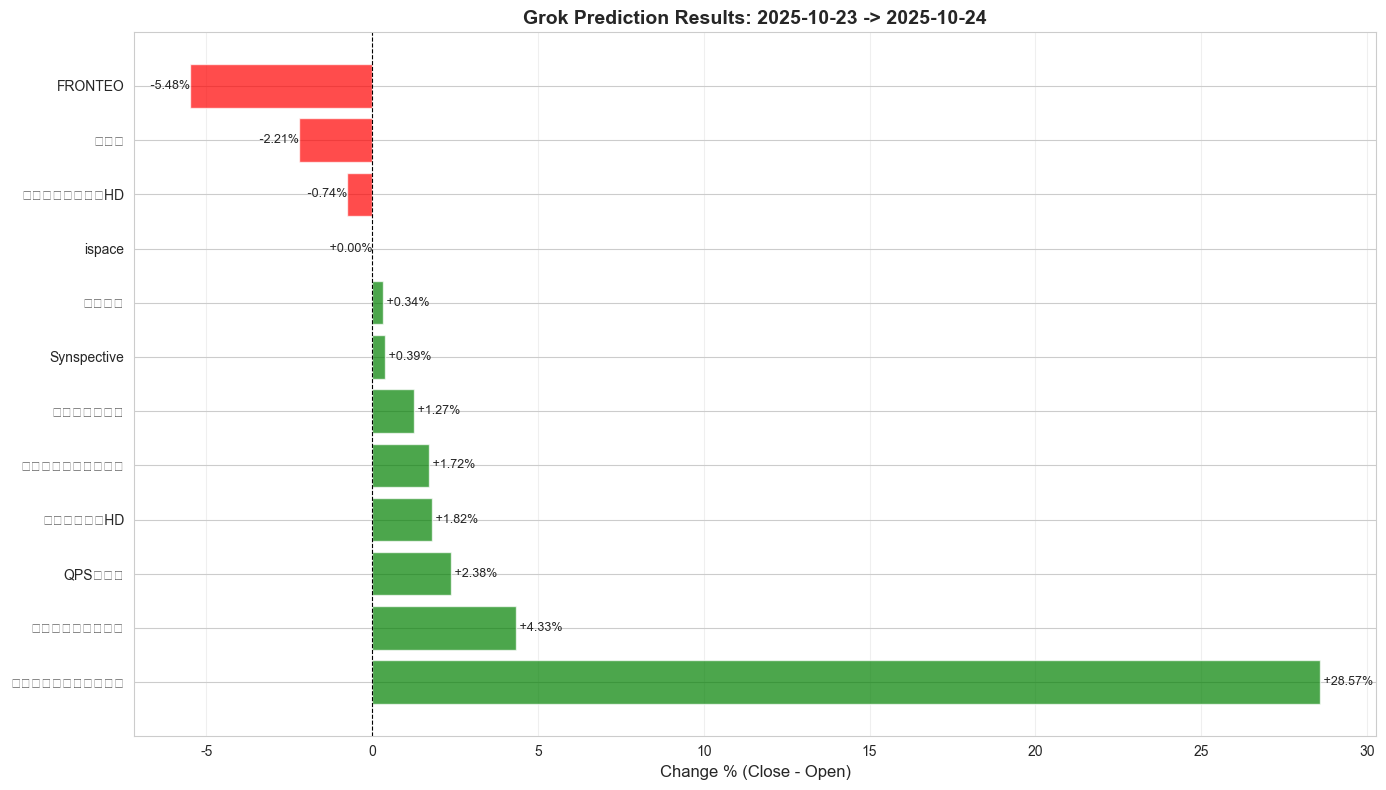

In [5]:
# 変化率でソート
df_sorted = df_valid.sort_values('change_pct', ascending=False)

# 棒グラフ
fig, ax = plt.subplots(figsize=(14, 8))

colors = ['green' if x > 0 else 'red' for x in df_sorted['change_pct']]
bars = ax.barh(df_sorted['name'], df_sorted['change_pct'], color=colors, alpha=0.7)

ax.set_xlabel('Change % (Close - Open)', fontsize=12)
ax.set_title('Grok Prediction Results: 2025-10-23 -> 2025-10-24', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# 値を表示
for i, (idx, row) in enumerate(df_sorted.iterrows()):
    ax.text(row['change_pct'], i, f" {row['change_pct']:+.2f}%", 
            va='center', ha='left' if row['change_pct'] > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.show()

## 5. 可視化：センチメントスコア vs 実績

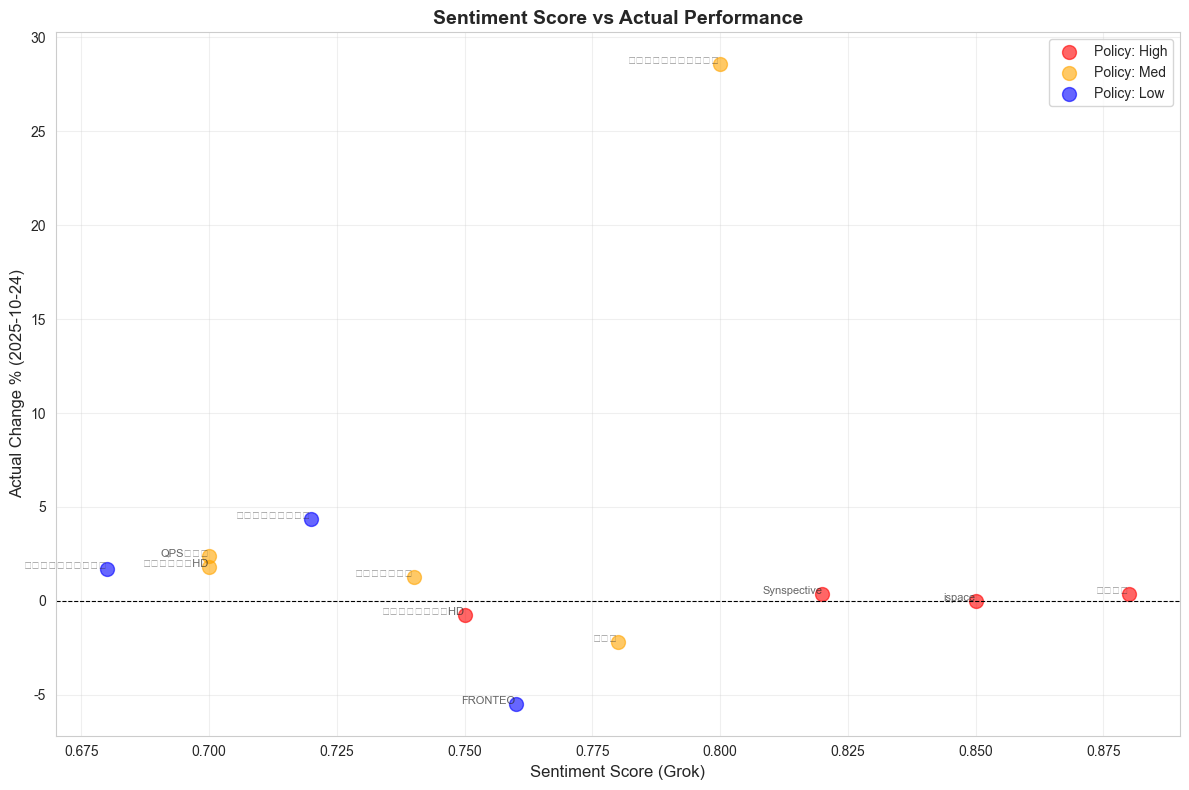

In [6]:
# センチメントスコア vs 変化率の散布図
fig, ax = plt.subplots(figsize=(12, 8))

colors_map = {'High': 'red', 'Med': 'orange', 'Low': 'blue'}
for policy in ['High', 'Med', 'Low']:
    subset = df_valid[df_valid['policy_link'] == policy]
    ax.scatter(subset['sentiment_score'], subset['change_pct'], 
               label=f'Policy: {policy}', s=100, alpha=0.6, color=colors_map[policy])

ax.set_xlabel('Sentiment Score (Grok)', fontsize=12)
ax.set_ylabel('Actual Change % (2025-10-24)', fontsize=12)
ax.set_title('Sentiment Score vs Actual Performance', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.grid(alpha=0.3)
ax.legend()

# 銘柄名を表示
for idx, row in df_valid.iterrows():
    ax.annotate(row['name'], (row['sentiment_score'], row['change_pct']), 
                fontsize=8, alpha=0.7, ha='right')

plt.tight_layout()
plt.show()

## 6. 詳細テーブル（ソート可能）

In [7]:
# スタイル付きテーブル
def color_result(val):
    if val == '上昇':
        color = 'lightgreen'
    elif val == '下落':
        color = 'lightcoral'
    else:
        color = 'lightgray'
    return f'background-color: {color}'

def color_change(val):
    if pd.isna(val):
        return ''
    color = 'green' if val > 0 else 'red'
    return f'color: {color}; font-weight: bold'

styled_df = df_results[['ticker', 'name', 'mentioned_by_str', 'policy_link', 'sentiment_score', 
                        'open', 'close', 'change_pct', 'range_pct', 'result']].style\
    .applymap(color_result, subset=['result'])\
    .applymap(color_change, subset=['change_pct'])\
    .format({
        'sentiment_score': '{:.2f}',
        'open': '{:.1f}',
        'close': '{:.1f}',
        'change_pct': '{:+.2f}%',
        'range_pct': '{:.2f}%'
    }, na_rep='-')

print("\n【詳細結果テーブル】")
display(styled_df)


【詳細結果テーブル】


,ticker,name,mentioned_by_str,policy_link,sentiment_score,open,close,change_pct,range_pct,result
0,9348,ispace,@kabuchenko,High,0.85,478.0,478.0,+0.00%,1.67%,下落
1,3929,Synspective,@kaikai2120621,High,0.82,258.0,259.0,+0.39%,1.16%,上昇
2,5595,QPS研究所,なし,Med,0.70,1935.0,1981.0,+2.38%,6.25%,上昇
3,6237,ウエスト,@kabu777b,High,0.88,2627.0,2636.0,+0.34%,1.33%,上昇
4,6264,イワキ,なし,Med,0.78,2122.0,2075.0,-2.21%,4.90%,下落
5,186A,アストロスケールHD,@daykabu2021,High,0.75,811.0,805.0,-0.74%,4.69%,下落
6,2459,アウンコンサルティング,@jestryoR,Med,0.80,252.0,324.0,+28.57%,28.57%,上昇
7,3079,ディーブイエックス,なし,Low,0.72,1316.0,1373.0,+4.33%,9.50%,上昇
8,3664,モブキャストHD,なし,Med,0.70,55.0,56.0,+1.82%,14.55%,上昇
9,2158,FRONTEO,@tesuta001,Low,0.76,1004.0,949.0,-5.48%,6.97%,下落


## 7. 結論

- **勝率**: プレミアムユーザー言及の有無による差を確認
- **センチメントスコア**: 高スコアが実際の上昇と相関しているか
- **政策連動度**: Highの銘柄が実際に動いたか

次回のプロンプト改善に活用してください！